一些思考:
- from scipy import stats
- stats.levene?

- stats.pearsonr??

# 读取数据
## 导入相关的库 
- 导入相关的库，同时，进行一些初始化的设置

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

sns.set(style="darkgrid")
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'numpy'

## 加载数据集

In [73]:
data = pd.read_csv("./data.csv")
print(data.shape)
# 加载之后可以使用head/tail/sample等方法查看数据的大致情况
data.sample(5)
# 修改列名
data.rename(columns={"Incineration(10,000ton)": "Incineration"}, inplace=True)
# 再次查看
data.sample(5)

(325, 12)


,City,AQI,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,Coastal,GreenCoverageRate,Incineration
241,Wendeng City,41,708.0,829.70,13.397260,122.057988,37.193882,45.0,360,是,46.00,25.00
143,Liuzhou City,41,1229.0,2298.62,21.884932,109.402809,24.310406,91.0,3517,否,42.95,49.83
72,Heyuan City,16,1700.0,810.08,22.772603,114.693817,23.734840,34.0,8950,否,30.70,21.34
202,Shanghai Municipality,46,1651.5,24964.99,17.916438,121.469269,31.238176,16.0,3804,是,34.00,613.85
303,Changhua County,38,1775.0,1356.00,22.600000,120.516135,24.051796,14.0,1200,是,46.00,24.00


# 数据清洗
## 缺失值

In [3]:
# 查看缺失值的方法： info、isnull
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 12 columns):
City                 325 non-null object
AQI                  325 non-null int64
Precipitation        321 non-null float64
GDP                  325 non-null float64
Temperature          325 non-null float64
Longitude            325 non-null float64
Latitude             325 non-null float64
Altitude             325 non-null float64
PopulationDensity    325 non-null int64
Coastal              325 non-null object
GreenCoverageRate    325 non-null float64
Incineration         325 non-null float64
dtypes: float64(8), int64(2), object(2)
memory usage: 30.5+ KB


In [4]:
data.isnull().sum(axis=0)

City                 0
AQI                  0
Precipitation        4
GDP                  0
Temperature          0
Longitude            0
Latitude             0
Altitude             0
PopulationDensity    0
Coastal              0
GreenCoverageRate    0
Incineration         0
dtype: int64

从结果得知，降雨量（Precipitation）存在4处缺失

### 缺失值处理
对于缺失值常用的几种处理方式有：
- 删除缺失值：仅适用于缺失数量很少的情况
- 填充缺失值：
    1. 数值变量：
        1. 均值填充 ：mean
        2. 中值填充 ：median
    2. 类别变量：
        1.众数填充 ：mode
        2.单独作为一个类别
    3. 额外处理说明：
        1. 缺失值少于 20%，直接填充
        2. 缺失值在 20% - 80%，填充变量后同时增加一列，标记该列是否缺失，参与后续建模 
        3. 缺失值大于 80%，不使用原始列，标记该列是否是缺失值，参与后续建模
    4. 其他填充方法：
        1. 前向填充：ffill
        2. 后向填充：bfill
        3. 常值填充

### 数据分布

0.27360760671177387


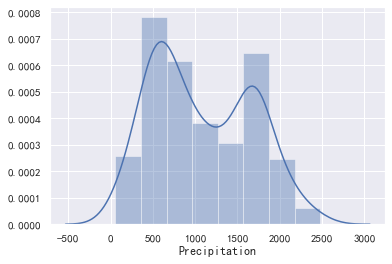

In [5]:
print(data["Precipitation"].skew())
sns.distplot(data["Precipitation"].dropna())

### 填充数据

In [74]:
# 此处采用中值填充，提供两种实现方式
# data.fillna({"Precipitation": data["Precipitation"].median()}, inplace=True)
data.Precipitation.fillna(data["Precipitation"].median(), inplace=True)
data.isnull().sum()

City                 0
AQI                  0
Precipitation        0
GDP                  0
Temperature          0
Longitude            0
Latitude             0
Altitude             0
PopulationDensity    0
Coastal              0
GreenCoverageRate    0
Incineration         0
dtype: int64

## 异常值

### 异常值探索
我们可以采用如下方式发现异常值：
- 通过describe方法查看数据信息
- 3σ方式
- 使用箱线图辅助
- 相关异常检测算法

#### describle方法
调用DataFrame对象的describe方法，可以显示数据的统计信息，不过，此方法仅能作为一种简单的异常值探索方法

In [7]:
data.describe()
# 可指定参数include参看非数字类型字段信息
# data.describe(include="all")

,AQI,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,GreenCoverageRate,Incineration
count,325.000000,325.0000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,75.809231,1079.3520,2390.901815,15.980149,113.990609,31.870665,380.141846,2610.883077,38.347969,52.315108
std,43.610516,583.5252,3254.876921,5.016133,7.688515,6.093703,741.409703,2910.679547,6.319706,91.707838
min,12.000000,56.1000,22.500000,-2.500000,80.105800,18.234043,-12.000000,1.000000,7.600000,1.530000
25%,45.000000,581.0000,762.970000,13.727397,111.130000,27.695387,18.000000,721.000000,35.530000,18.890000
50%,69.000000,920.0000,1328.520000,16.494521,115.500183,31.385597,62.000000,1790.000000,38.690000,24.000000
75%,102.000000,1651.0000,2735.340000,18.921918,119.823308,36.449432,354.000000,3517.000000,42.620000,37.630000
max,296.000000,2478.1000,24964.990000,27.447945,129.598496,49.220000,4505.000000,25900.000000,76.490000,686.670000


#### 3σ方法
根据正态分布的特性，我们可以将3σ之外的数据视作异常值。
- 以GDP为例，首先绘制GDP的分布

3.7614282419643033


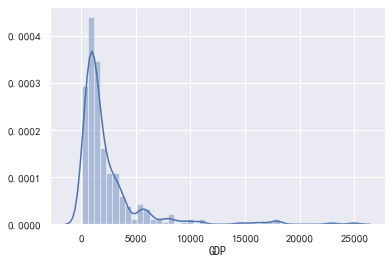

In [8]:
sns.distplot(data["GDP"])
print(data["GDP"].skew())

可以看出，该数据呈现严重的右偏分布。也就是存在很多极大的异常值，我们可以获取这些异常值

In [9]:
mean, std = data["GDP"].mean(), data["GDP"].std()
lower, upper = mean - 3 * std, mean + 3 * std

print("均值：", mean)
print("标准差：", std)
print("上限：%10.3f" % upper)
print("下限：%10.3f" % lower)
data["GDP"][(data["GDP"] < lower) | (data["GDP"] > upper)]

均值： 2390.901815384616
标准差： 3254.876921271434
上限： 12155.533
下限： -7373.729


16     22968.60
63     18100.41
202    24964.99
207    17502.99
215    14504.07
230    16538.19
256    17900.00
314    15719.72
Name: GDP, dtype: float64

#### 箱线图
箱线图是一种常见的异常值检测方式

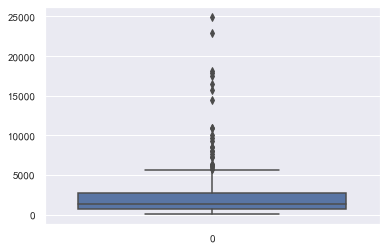

In [10]:
sns.boxplot(data=data["GDP"])

### 异常值处理
对于异常值，我们常用如下的处理方式：
- 删除异常值
- 视为缺失值处理
- 对数转换（右偏）
- 使用临界值填充
- 使用分箱法离散化处理

#### 对数转换
如果数据中存在较大的异常值，我们可以通过取对数的方法来进行转换，这样可以使大数值数据的影响得到一定的缓解
- 例如，GDP变量呈现右偏分布，我们可以进行取对数转换

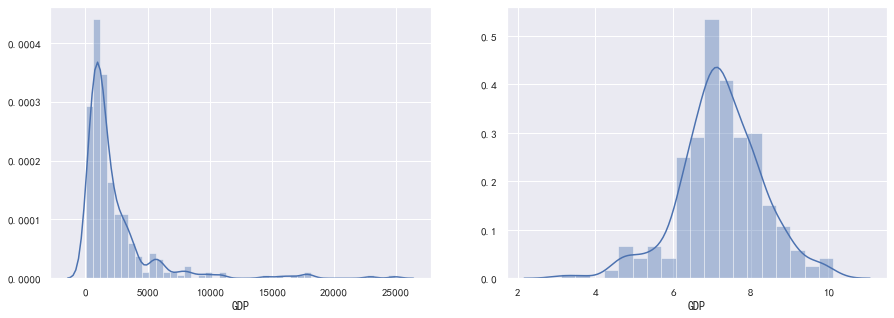

In [11]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.distplot(data["GDP"], ax=ax[0])
sns.distplot(np.log(data["GDP"]), ax=ax[1])

取对数的放方式比较简单，不过存在一些局限：
- 取对数只能针对正数进行操作，不过对于存在负数的数据，我们可以通过如下方式进行转换：
\begin{equation} np.sign(X)*np.log(np.abs(X)+1) \end{equation}
- 适用于右偏分布，不适用于左偏分布

#### 使用边界值替换
我们可以对异常值进行“截断”处理，即使用临界值替换异常值。
- 例如：在3σ与箱线图中，即可如此处理

#### 分箱离散化
有时候，有时候特征对目标值存在一定的影响，但是这种影响可能不是线性的。此时，我们可以使用分箱方式，对特征进行离散化处理

### 重复值
#### 重复值探索
- 使用duplicated检查重复值。可配合keep参数进行调整
        subset : column label or sequence of labels, optional
            Only consider certain columns for identifying duplicates, by
            default use all of the columns
        keep : {'first', 'last', False}, default 'first'
            - ``first`` : Mark duplicates as ``True`` except for the
              first occurrence.
            - ``last`` : Mark duplicates as ``True`` except for the
              last occurrence.
            - False : Mark all duplicates as ``True``.

In [75]:
# 发现重复值
print(data.duplicated().sum())
# 查看哪些记录出现了重复值
data[data.duplicated(keep=False)]

2


,City,AQI,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,Coastal,GreenCoverageRate,Incineration
13,Baoding City,220,566.9,2757.80,13.258904,115.500183,38.857071,17.2,4565,否,30.96,49.27
109,Baoding City,220,566.9,2757.80,13.258904,115.500183,38.857071,17.2,4565,否,30.96,49.27
149,Luohe City,85,831.0,992.85,15.704110,114.041092,33.572510,62.0,5283,否,34.39,22.00
218,Luohe City,85,831.0,992.85,15.704110,114.041092,33.572510,62.0,5283,否,34.39,22.00


#### 重复值处理
对于重复值，通常进行删除处理

In [76]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

# 数据分析
## 空气质量最好/最差的5个城市
空气质量好坏可以为我们以后选择工作、定居、旅游等地提供参考

### 空气最好的5个城市

,City,AQI
204,Shaoguan City,12
163,Nanping City,12
154,Meizhou City,12
91,Keelung City,13
195,Sanming City,13


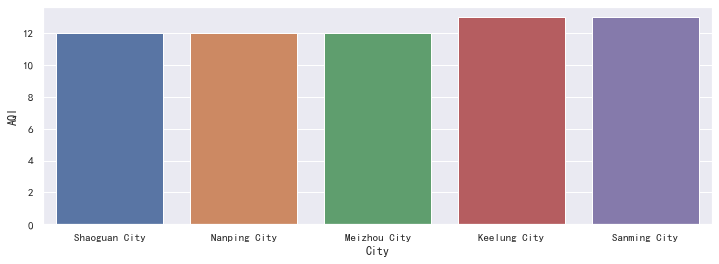

In [14]:
t = data[["City", "AQI"]].sort_values("AQI")
# t.head()
display(t.iloc[:5])
plt.figure(figsize=[12,4])
# plt.xticks(rotation=45)
sns.barplot(x="City", y="AQI", data=t.iloc[:5])

我们发现，空气最好的5个城市为：
- 韶关市
- 南平市
- 梅州市
- 基隆市
- 三明市

### 空气最差的5个城市

,City,AQI
16,Beijing City,296
26,Chaoyang City,224
13,Baoding City,220
112,Jinzhou City,202
105,Jiaozuo City,199


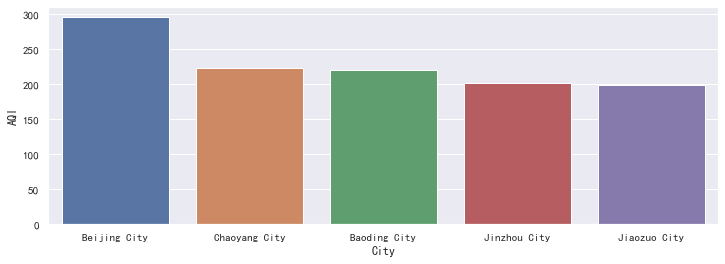

In [15]:
# 方法一：倒序取前五
t1 = data[["City", "AQI"]].sort_values("AQI", ascending=False)
display(t1.iloc[:5])
plt.figure(figsize=[12, 4])
sns.barplot(x="City", y="AQI", data=t1.iloc[:5])

,City,AQI
105,Jiaozuo City,199
112,Jinzhou City,202
13,Baoding City,220
26,Chaoyang City,224
16,Beijing City,296


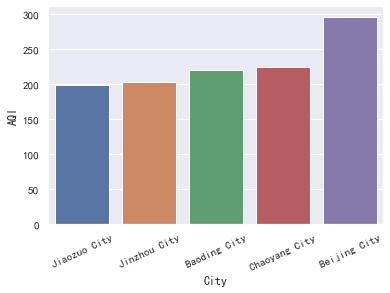

In [16]:
# 方法二：顺序取倒数五个城市
display(t.iloc[-5:])
plt.xticks(rotation=25)
sns.barplot(x="City",y="AQI",data=t.iloc[-5:])

我们得出空气质量最差的5个城市为：
- 北京市
- 朝阳市
- 保定市
- 锦州市
- 焦作市

## 全国城市的空气质量
### 城市空气质量等级划分，划分标准如下：
| AQI指数 | 等级| 描述|
| ------ |:-------:|:-----:|
| 0-50   | 一级| 优 |
| 51-100| 二级| 良|
| 101-150| 三级| 轻度污染|
| 151-200| 四级| 中度污染|
| 201-300| 五级| 重度污染|
| >300 | 六级 | 严重污染 |


根据标准，我们可以统计全国空气质量每个等级的数量

二级    136
一级    103
三级     66
四级     14
五级      4
Name: AQI, dtype: int64

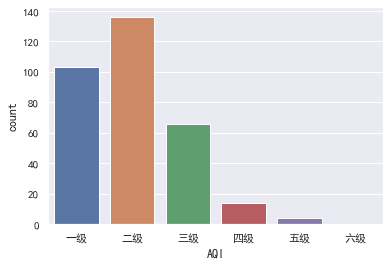

In [17]:
# 编写函数，将AQI转换为对应等级
def value_to_level(AQI):
    if AQI >= 0 and AQI <= 50:
        return "一级"
    elif AQI > 50 and AQI <= 100:
        return "二级"
    elif AQI > 100 and AQI <= 150:
        return "三级"
    elif AQI > 150 and AQI <= 200:
        return "四级"
    elif AQI > 200 and AQI <= 300:
        return "五级"
    else:
        return "六级"

level = data["AQI"].apply(value_to_level)
display(level.value_counts())
sns.countplot(x=level,order=["一级","二级","三级","四级","五级","六级"])

可见，我国城市的空气质量主要以一级（优）与二级（良）为主，三级（轻度污染）占一部分，更高污染的城市占少数

### 空气质量指数分布
绘制全国各城市的空气质量指数分布图

In [77]:
import plotly.graph_objects as go
import plotly as py
my_map = go.Densitymapbox(lat=data['Latitude'],
                          lon=data['Longitude'],
                          z=data['AQI'],
                          colorscale='Picnic',
                          radius=15)
fig = go.Figure(my_map)
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=100)
py.offline.plot(fig, filename="map.html")

'map.html'

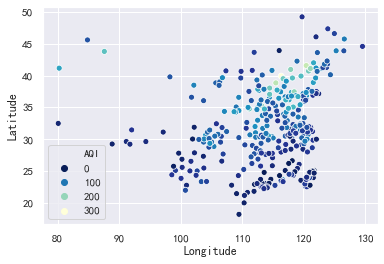

In [19]:
sns.scatterplot(x="Longitude",
                y="Latitude",
                hue="AQI",
                palette=plt.cm.YlGnBu_r,
                data=data)

从结果可以发现，从大致的地理位置上看，西部城市空气质量好于东部城市，南部城市的空气质量优于北部城市

## 临海城市空气质量是否优于内陆城市？

### 数量统计
我们首先统计一下临海城市与内陆城市的数量

否    243
是     80
Name: Coastal, dtype: int64

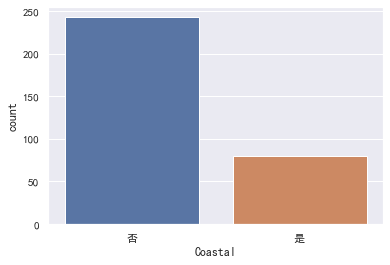

In [20]:
display(data["Coastal"].value_counts())
sns.countplot(x="Coastal", data=data)

### 分布统计
然后，我们来观察一下临海城市与内陆城市的AQI散点分布

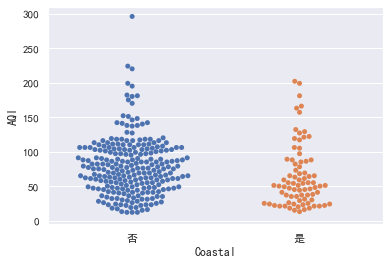

In [21]:
# sns.stripplot(x="Coastal",y="AQI",data=data)
sns.swarmplot(x="Coastal", y="AQI", data=data)

我们对是否沿海，分组进行均值计算

Coastal
否    79.045267
是    64.062500
Name: AQI, dtype: float64

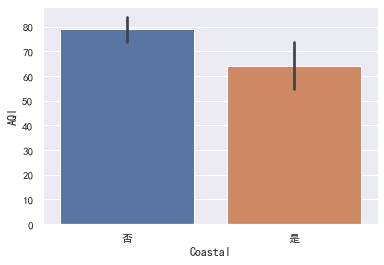

In [22]:
display(data.groupby("Coastal")["AQI"].mean())
sns.barplot(x="Coastal", y="AQI", data=data)

在柱形图中，仅显示了内陆城市与沿海城市空气质量指数（AQI）的均值对比，我们可以使用箱线图或小提琴图来显示更多的信息

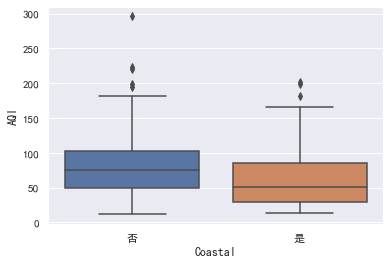

In [23]:
# 箱线图
sns.boxplot(x="Coastal", y="AQI", data=data)

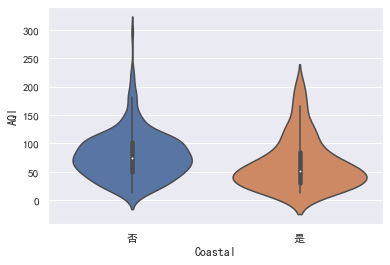

In [24]:
# 小提琴图,小提琴图除了能显示箱线图的信息，还可以呈现出数据的分布情况
sns.violinplot(x="Coastal", y="AQI", data=data)

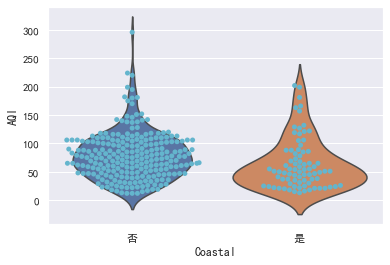

In [25]:
# 也可将散点图与小提琴图或箱线图一同绘制
# 蜂群图+小提琴图
sns.violinplot(x="Coastal", y="AQI", data=data, inner=None)
sns.swarmplot(x="Coastal", y="AQI", data=data, color="c")

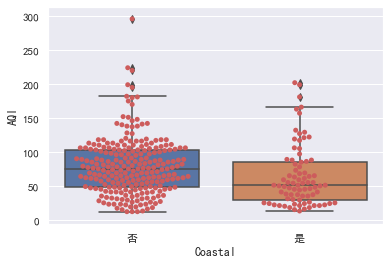

In [26]:
# 蜂群图+箱线图
sns.boxplot(x="Coastal",y="AQI",data=data)
sns.swarmplot(x="Coastal",y="AQI",data=data,color="indianred")

### 差异检验
这里，我们可以进行双样本$ t $检验,来查看沿海城市与内陆城市的均值差异是否显著

In [27]:
from scipy import stats

coastal = data[data["Coastal"] == "是"]["AQI"]
inland = data[data["Coastal"] == "否"]["AQI"]

# 进行方差齐性检验，为后续进行双样本t检验服务
# 方差反映了一组数据与其平均值的偏离程度，
# 方差齐性检验用以检验两组或多组数据与其均值偏离程度是否存在差异，
# 也是很多检验和算法的先决条件
stats.levene(coastal, inland)

LeveneResult(statistic=0.08825036641952543, pvalue=0.7666054880248168)

返回结果 pvalue=0.7666054880248168, 比指定的显著水平（假设为5%）大，认为两组数据具有方差齐性。

In [28]:
# 进行两样本t检验
# 两样本的方差相同与不同，其t检验结果是不同的
r = stats.ttest_ind(coastal, inland, equal_var=True)
print(r)
p = stats.t.sf(r.statistic, df=len(coastal) + len(inland) - 2)
print(p)

Ttest_indResult(statistic=-2.7303827520948905, pvalue=0.006675422541012958)
0.9966622887294936


1. r值结果分析：
    1. 返回结果的第一个值为统计量，statistic=-2.73038275为负，
        即coastal其AQI值比inland的AQI值要小
    2. 第二个值为p-value，
        pvalue=0.0066754225410，比指定的显著水平（一般为5%）小，
        即拒绝原假设，两组数据之间有差异。
2. p值结果分析：
    1. p=0.9966622887294936，即有超过99%的几率，可以认为沿海城市的空气质量普遍优于内陆城市

## 探索空气质量主要受哪些因素影响

除了地理位置（是否沿海）对空气质量的影响，我们可能会有如下疑问：
1. 人口密度是否会对空气质量产生负面影响
2. 提升绿化率，能否提高空气质量
3. 焚烧量对空气质量的影响程度
...


### 散点图矩阵

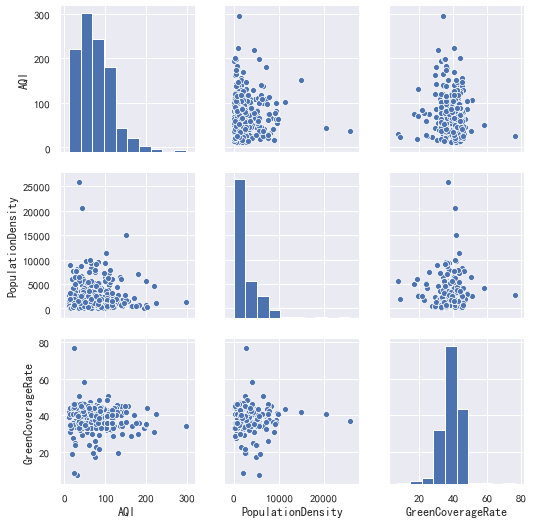

In [29]:
# 例如：探究人口密度、绿化率对AQI的影响
sns.pairplot(data[["AQI", "PopulationDensity", "GreenCoverageRate"]],
             kind="scatter")

In [ ]:
# import plotly.express as px
# fig = px.scatter_matrix(
#     data,
#     dimensions=["AQI", "PopulationDensity", "GreenCoverageRate"],
#     opacity=0.8)
# fig.show()

### 相关系数
1. 相关系数可以用来体现两个连续变量间的相关性，最为常用的是Pearson相关系数、Spearman相关系数
相关系数的取值范围是[-1, 1]，我们可以根据相关系数的取值来衡量两个变量之间的相关性（正数为正相关，负数为负相关）
- 0.8-1.0：极强相关
- 0.6-0.8：强相关
- 0.4-0.6：中等程度相关
- 0.2-0.4：弱相关
- 0.0-0.2：极弱相关

我们以空气质量（AQI）与焚烧量（Incineration）为例，计算二者间的相关系数

- 皮尔森相关系数（Pearson correlation coefficient）是反应俩变量之间线性相关程度的统计量，用它来分析正态分布的两个连续型变量之间的相关性。常用于分析自变量之间，以及自变量和因变量之间的相关性。
- 斯皮尔曼等级相关系数(Spearman’s correlation coefficient for ranked data )，它主要用于评价顺序变量间的线性相关关系，在计算过程中，只考虑变量值的顺序（rank, 秩或称等级），而不考虑变量值的大小。常用于计算类型变量的相关性。
    -  返回结果的第一个值为相关系数表示线性相关程度，其取值范围在[-1,1]，绝对值越接近1，说明两个变量的相关性越强，绝对值越接近0说明两个变量的相关性越差。当两个变量完全不相关时相关系数为0。第二个值为p-value，统计学上，一般当p-value<0.05时，可以认为两变量存在相关性。

In [30]:
x = data["AQI"]
y = data["Incineration"]
# 计算AQI与Incineration间的协方差
# 协方差体现两个变量之间的分散性及两个变量之间的变化步调是否一致
a = (x - x.mean()) * (y - y.mean())
cov = np.sum(a) / (len(a) - 1)
print("协方差：%.3f " % cov)
# 计算AQI与Incineration间的相关系数
# corr = cov / np.sqrt(x.var() * y.var())
corr = cov / (x.std() * y.std())
print("相关系数：%.3f " % corr)

协方差：422.739 
相关系数：0.107 


我们可以得到QI与Incineration间的相关系数为：0.107 ，即两者间呈极弱相关 

In [31]:
# 通过data.corr计算所有特征两两间的相关系数
data.corr()

,AQI,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,GreenCoverageRate,Incineration
AQI,1.000000,-0.401844,0.160341,-0.283956,0.093900,0.552652,-0.204753,-0.026496,-0.097734,0.106898
Precipitation,-0.401844,1.000000,0.176665,0.685447,0.223211,-0.656175,-0.324124,0.067047,0.153291,0.201174
GDP,0.160341,0.176665,1.000000,0.145780,0.173041,-0.010124,-0.208952,0.229402,-0.039220,0.899550
Temperature,-0.283956,0.685447,0.145780,1.000000,0.141277,-0.807119,-0.459426,0.144923,0.216575,0.173590
Longitude,0.093900,0.223211,0.173041,0.141277,1.000000,0.173585,-0.737548,-0.121986,0.156439,0.072068
Latitude,0.552652,-0.656175,-0.010124,-0.807119,0.173585,1.000000,0.002571,-0.167384,-0.142776,-0.081412
Altitude,-0.204753,-0.324124,-0.208952,-0.459426,-0.737548,0.002571,1.000000,-0.031408,-0.182449,-0.122192
PopulationDensity,-0.026496,0.067047,0.229402,0.144923,-0.121986,-0.167384,-0.031408,1.000000,0.021197,0.283563
GreenCoverageRate,-0.097734,0.153291,-0.039220,0.216575,0.156439,-0.142776,-0.182449,0.021197,1.000000,-0.029088
Incineration,0.106898,0.201174,0.899550,0.173590,0.072068,-0.081412,-0.122192,0.283563,-0.029088,1.000000


In [38]:
# 同时获得coefficient 和 p-value
aqi_corr = data[[
    "Precipitation", "Temperature", "Longitude", "Latitude", "Altitude",
    "Incineration"
]].apply(lambda x: stats.pearsonr(data['AQI'], x))
aqi_corr

Precipitation       (-0.4018440700301392, 5.77544070660388e-14)
Temperature      (-0.28395579153026884, 2.0943718956473814e-07)
Longitude            (0.09389958453082473, 0.09203413443100286)
Latitude           (0.5526515215963935, 3.1546058622883533e-27)
Altitude         (-0.20475299522503526, 0.00021145525981066765)
Incineration         (0.10689802611240584, 0.05495304814868732)
dtype: object

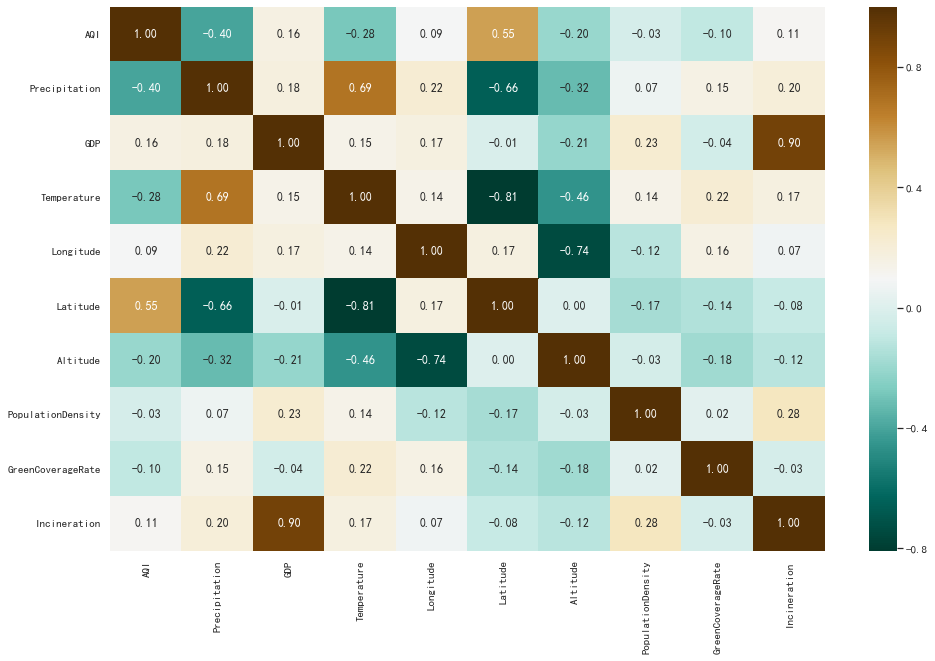

In [40]:
# 为了更清晰地展示相关系数数值，可以通过热图的方式进行展示
plt.figure(figsize=(16, 10))
ax = sns.heatmap(data.corr(), cmap=plt.cm.BrBG_r, annot=True, fmt=".2f")

### 统计结果
从结果中可以得到，空气指数主要受Precipitation降雨量（-0.40）及Latitude纬度（0.55）影响
- 降雨量越多，空气质量越好
- 维度越低，空气质量越好 
1. 此外，我们还可以发现如下细节：
    - GDP与Incineration（焚烧量）正相关：0.90
    - Temperature（温度）与Latitude（纬度）负相关：-0.81
    - longitude（经度）与Altitude（海拔）负相关：-0.74
    - Temperature（温度）与Precipitation（降雨量）正相关：0.69
    - Latitude（纬度）与Precipitation（降雨量）负相关：-0.66
    - Temperature（温度）与Altitude（海拔）负相关：-0.46
    - Altitude（海拔）与Precipitation（降雨量）负相关：-0.32


## 关于空气质量的验证
有一种说法：全国所有城市空气质量指数均值在71左右。思考：这个说法是否准确

计算城市空气质量指数平均值

In [41]:
data["AQI"].mean()

75.3343653250774

验证样本均值是否等于总体均值
根据场景，我们可以使用单样本t检验，置信度为95%

In [42]:
r = stats.ttest_1samp(data["AQI"], 71)
print("t值：", r.statistic)
print("p值：", r.pvalue)

t值： 1.8117630617496872
p值： 0.07095431526986647


从结果得知：p值为 0.07095431526986647 大于0.05，因此我们不能拒绝原假设，即不能否认上述说法

In [43]:
mean = data["AQI"].mean()
std = data["AQI"].std()
stats.t.interval(0.95,
                 df=len(data) - 1,
                 loc=mean,
                 scale=std / np.sqrt(len(data)))

(70.6277615675309, 80.0409690826239)

我们计算得出，全国所有城市平均空气质量指数，95%的可能在70.62 - 80.04之间 

## 空气质量预测

对于我国某城市，如果我们已知降雨量，温度，经纬度等指标，我们是否能够预测该城市的空气质量指数呢？答案是肯定的。我们可以通过以往的数据，去建立一种模型，然后将这种模型去应用于未知的数据，进而进行预测

### 数据转换
对于模型来说，内部进行的都是数学上的运算。进行建模之前，我们首先需要进行数据转换，将类别变量转化为离散变量

In [44]:
# 将Coastal特征数据类型转化为数值型
data["Coastal"] = data["Coastal"].map({"是": 1, "否": 0})
data["Coastal"].value_counts()

0    243
1     80
Name: Coastal, dtype: int64

### 基模型
首先，我们不进行任何处理，建立一个基模型。后续的操作，可以在此基础上进行改造

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = data.drop(["City", "AQI"], axis=1)
y = data["AQI"]
# 将数据划分为数据集与测试集
# test_size:测试集大小
# random_state：随机种子，用来产生相同的随机数系列
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)

In [46]:
lr = LinearRegression()
# 使用训练集，训练模型
lr.fit(X_train, y_train)
print("权重：", lr.coef_)
print("截距：", lr.intercept_)
# 从训练集学习到的模型参数（W与b），确定方程，就可以进行预测
y_hat = lr.predict(X_test)
print("实际值：", y_test[:5].values)
print("预测值：", y_hat[:5])
# score其实求解的就是r^2的值
print("训练集R^2：",lr.score(X_train, y_train))
print("测试集R^2：",lr.score(X_test, y_test))

权重： [-1.41820661e-02  8.39915117e-04  2.77161192e+00 -2.18874948e+00
  5.14507145e+00 -2.30706730e-02 -9.31494243e-05 -4.91015631e+00
 -5.31061503e-01  6.46846582e-02]
截距： 158.5095853657033
实际值： [119  61  23  81  76]
预测值： [106.33346402  53.59954189  57.06795841  83.76126675  94.38331118]
训练集R^2： 0.4538897765064036
测试集R^2： 0.40407705623832957


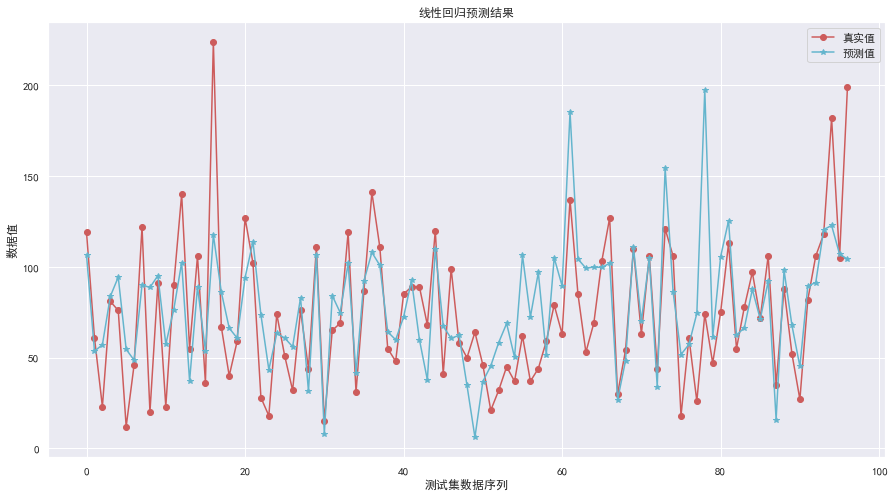

In [47]:
# 绘制预测结果图
plt.figure(figsize=(15, 8))
plt.plot(y_test.values, label="真实值", color="indianred", marker="o")
plt.plot(y_hat, label="预测值", color="c", marker="*")
plt.xlabel("测试集数据序列")
plt.ylabel("数据值")
plt.title("线性回归预测结果", fontsize=12)
plt.legend(loc=1)

### 特征选择
刚才，我们使用了所有有可能的原始数据作为特征，建立模型。然而，有时候特征并非越多越好，有些特征可能对模型质量并没有改善，我们可以删除这些特征。此外，删除这些特征还可以提高模型的训练速度。
#### RFECV方式
特征选择的方式有很多。这里，我们采用RFECV方式实现特征选择。RFECV分为两个部分：
- RFE(Recursive Feature elimination)：递归特征消除。用来对特征进行重要性评级
- CV(Cross Validation)：交叉验证。在特征评级后，进行交叉验证，选择最佳数量的特征
具体过程如下：
- RFE阶段：
    - 初始的特征集为所有可用的特征
    - 使用当前特征集进行建模，然后计算每个特征的重要性
    - 删除最不重要的一个（或多个）特征，更新特征集
    - 跳转到步骤2，知道完成所有特征的重要性评级
- CV阶段：
    - 根据RFE阶段确定的特征重要级，依次选择不同数量的特征
    - 对选定的特征集进行交叉验证
    - 确定平均分最高的特征数量，完成特征选择

#### 进行特征选择

In [48]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=lr,step=1,cv=5,n_jobs=-1,scoring="r2")
# estimator：要操作的模型
# step：每次删除的特征数量
# cv：使用交叉验证的折数
# n_jobs：并发的数量
# scoring：评估的方式
rfecv.fit(X_train, y_train)
# 返回经过选择之后，剩余的特征数量
print("剩余的特征数量:",rfecv.n_features_)
# 返回 经过特征选择后，使用缩减特征训练后的模型
print(rfecv.estimator_)
# 返回每个特征的等级，数值越小，等级越重要
print("特征的等级:",rfecv.ranking_)
# 返回布尔数组，用来表示特征是否被选择
print("特征是否被选择:",rfecv.support_)
# 返回对应数量特征时，模型交叉验证的得分
print("交叉验证得分:",rfecv.grid_scores_)

剩余的特征数量: 8
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
特征的等级: [1 2 1 1 1 1 3 1 1 1]
特征是否被选择: [ True False  True  True  True  True False  True  True  True]
交叉验证得分: [-0.06091362  0.1397744   0.2302962   0.22814855  0.22644355  0.21342713
  0.24573222  0.26368987  0.25744818  0.25389817]


通过结果可知，删除两个特征后交叉验证的分最高。

Text(0, 0.5, '交叉验证$R^2$值')

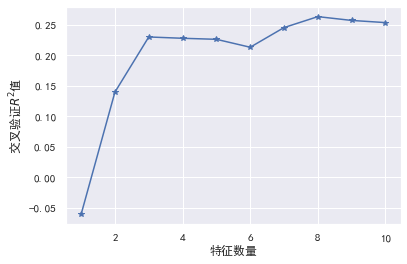

In [49]:
# 绘制交叉验证的得分情况
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker="*")
plt.xlabel("特征数量")
plt.ylabel("交叉验证$R^2$值")

我们对测试集应用上述特征选择结果，进行测试，并获得测试结果

In [50]:
print("选择的变量：", X_train.columns[rfecv.support_])
print("剔除的变量：", X_train.columns[~rfecv.support_])
X_train_eli = rfecv.transform(X_train)
X_test_eli = rfecv.transform(X_test)
print(rfecv.estimator_.score(X_train_eli, y_train))
print(rfecv.estimator_.score(X_test_eli, y_test))

选择的变量： Index(['Precipitation', 'Temperature', 'Longitude', 'Latitude', 'Altitude',
       'Coastal', 'GreenCoverageRate', 'Incineration'],
      dtype='object')
剔除的变量： Index(['GDP', 'PopulationDensity'], dtype='object')
0.45322255556356406
0.39822556329576053


经过特征选择，剔除掉了'GDP'与 'PopulationDensity'两个特征，使用剩下的八个特征训练出的模型得分与剔除前的模型得分几乎相同。说明我们剔除的这两个特征，确实对模型拟合的目标没有什么帮助，可以去掉。

## 异常值处理
如果数据中存在异常值，很有可能会影响到模型的拟合效果。因此，在建模之前，我们应该先对异常值进行处理

### 使用临界值替换
我们可以依据箱线图判断离群点的原则去探索异常值，然后使用临界值替代异常值

In [51]:
# Coastal是类别变量，将其映射为离散变量，不会存在异常值
for col in X.columns.drop("Coastal"):
    if pd.api.types.is_numeric_dtype(X_train[col]):
        quartile = np.quantile(X_train[col], [0.25, 0.75])
        IQR = quartile[1] - quartile[0]
        lower = quartile[0] - 1.5 * IQR
        upper = quartile[1] + 1.5 * IQR
        X_train[col][X_train[col] < lower] = lower
        X_train[col][X_train[col] > upper] = upper
        X_test[col][X_test[col] < lower] = lower
        X_test[col][X_test[col] > upper] = upper

In [52]:
X_train.sample(5)

,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,Coastal,GreenCoverageRate,Incineration
285,1200.0,1320.00,16.545205,119.823308,31.340637,34.00,530.0,0,33.000,14.0000
190,377.0,168.00,6.300000,98.329434,29.266869,910.15,2700.0,0,52.985,4.1300
223,581.0,3558.13,16.800000,121.430000,28.680000,14.00,1378.0,1,38.550,51.6525
179,458.0,1333.64,14.716438,115.014954,35.701897,55.00,3384.0,0,38.400,21.9000
304,1670.0,2767.45,23.284932,117.653091,24.518164,19.00,388.0,1,45.000,24.0000


### 效果对比
去除异常值后，我们使用新的训练集与测试集来评估模型效果

In [53]:
lr.fit(X_train, y_train)
print("训练集R^2：", lr.score(X_train, y_train))
print("测试集R^2：", lr.score(X_test, y_test))

训练集R^2： 0.4631142291492415
测试集R^2： 0.4461420265839771


对比一下效果，发现似乎还是有轻微的改进，不过不是很明显。我们可以使用RFECV在去除异常值的数据的基础上，再次进行尝试。

剩余的特征数量: 9
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
特征的等级: [1 1 1 1 1 1 2 1 1 1]
特征是否被选择: [ True  True  True  True  True  True False  True  True  True]
交叉验证得分: [-0.06091362  0.1397744   0.19933237  0.16183209  0.18281661  0.20636585
  0.29772708  0.307344    0.30877162  0.30022701]


Text(0, 0.5, '交叉验证$R^2$值')

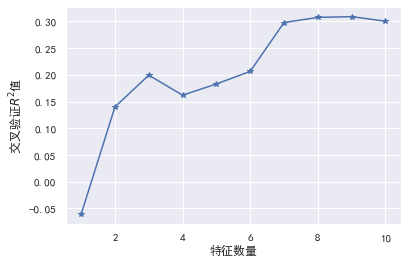

In [54]:
# 再次进行特征选择，并绘制交叉验证的得分情况
rfecv = RFECV(estimator=lr,step=1,cv=5,n_jobs=-1,scoring="r2")
rfecv.fit(X_train, y_train)
print("剩余的特征数量:",rfecv.n_features_)
print(rfecv.estimator_)
print("特征的等级:",rfecv.ranking_)
print("特征是否被选择:",rfecv.support_)
print("交叉验证得分:",rfecv.grid_scores_)

# 绘制交叉验证的得分情况
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker="*")
plt.xlabel("特征数量")
plt.ylabel("交叉验证$R^2$值")

In [55]:
print("选择的变量：", X_train.columns[rfecv.support_])
print("剔除的变量：", X_train.columns[~rfecv.support_])
X_train_eli = X_train[X_train.columns[rfecv.support_]]
X_test_eli = X_test[X_test.columns[rfecv.support_]]
print(rfecv.estimator_.score(X_train_eli, y_train))
print(rfecv.estimator_.score(X_test_eli, y_test))

选择的变量： Index(['Precipitation', 'GDP', 'Temperature', 'Longitude', 'Latitude',
       'Altitude', 'Coastal', 'GreenCoverageRate', 'Incineration'],
      dtype='object')
剔除的变量： Index(['PopulationDensity'], dtype='object')
0.4630665619148861
0.44502255894082554


### 分箱操作
注意：分箱后，我们不能讲每个区间映射为离散值，而应当使用One-Hot编码

KBinsDiscretizer K个分箱离散器，用于讲数值变量（通常是连续变量）进行区间离散化操作

| 参数 | 含义&输入 |
| ---- |: ------- :|
| n_bins | 每个特征中分箱的个数，默认5，一次会被运用到所有导入的特征 |
| encode | 编码的方式，默认“onehot” |
| strategy | 用来定义箱宽的方式，默认"quantile"  |

In [60]:
from sklearn.preprocessing import KBinsDiscretizer
k = KBinsDiscretizer(n_bins=[4, 5, 14, 6],
                     encode="onehot-dense",
                     strategy="uniform")
# KBinsDiscretizer K个分箱的离散器。用于将数值（通常是连续变量）变量进行区间离散化操作。
# n_bins：分箱（区间）的个数。
# encode：离散化编码方式。分为：onehot，onehot-dense与ordinal。
#     onehot：使用独热编码，返回稀疏矩阵。
#     onehot-dense：使用独热编码，返回稠密矩阵。
#     ordinal：使用序数编码（0,1,2……）。
# strategy：分箱的方式。分为：uniform，quantile，kmeans。
#     uniform：每个区间的长度范围大致相同。
#     quantile：每个区间包含的元素个数大致相同。
#     kmeans：使用一维kmeans方式进行分箱。

# 定义离散化的特征。
discretize = ["Longitude", "Temperature", "Precipitation", "Latitude"]

r = k.fit_transform(X_train_eli[discretize])
r = pd.DataFrame(r, index=X_train_eli.index)
# 获取除离散化特征之外的其他特征。
X_train_dis = X_train_eli.drop(discretize, axis=1)
# 将离散化后的特征与其他特征进行重新组合。
X_train_dis = pd.concat([X_train_dis, r], axis=1)
# 对测试集进行同样的离散化操作。
r = pd.DataFrame(k.transform(X_test_eli[discretize]), index=X_test_eli.index)
X_test_dis = X_test_eli.drop(discretize, axis=1)
X_test_dis = pd.concat([X_test_dis, r], axis=1)
# 查看转换之后的格式。
display(X_train_dis.head())

,GDP,Altitude,Coastal,GreenCoverageRate,Incineration,0,1,2,3,4,...,19,20,21,22,23,24,25,26,27,28
190,168.00000,910.15,0,52.985,4.1300,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
265,714.00000,30.00,1,46.000,24.0000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
215,5309.38125,6.00,0,34.000,51.6525,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
89,1235.00000,21.00,0,39.650,29.2000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
146,1291.38000,120.00,0,37.510,14.5000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [61]:
# 进行训练
lr.fit(X_train_dis, y_train)
print("训练集R^2：", lr.score(X_train_dis, y_train))
print("测试集R^2：", lr.score(X_test_dis, y_test))

训练集R^2： 0.6892388692774563
测试集R^2： 0.6546062348355675


可以看到，经过离散化处理之后，我们的模型效果又得到了一定程度上的提升

## 残差图分析
残差，就是模型预测值与真实值之间的差异。我们可以通过绘制残差图对模型进行评估。残差图中，横坐标为预测值，纵坐标为残差值

### 异方差性
对于一个好的回归模型，误差应该是随机分布的。因此，残差也应该随机分布在中心线附近。如果我们可以从残差图中找出规律，这意味着模型遗漏了某些能够影响残差的解释信息
- 异方差性，就是值残差具有明显的方差不一致性。

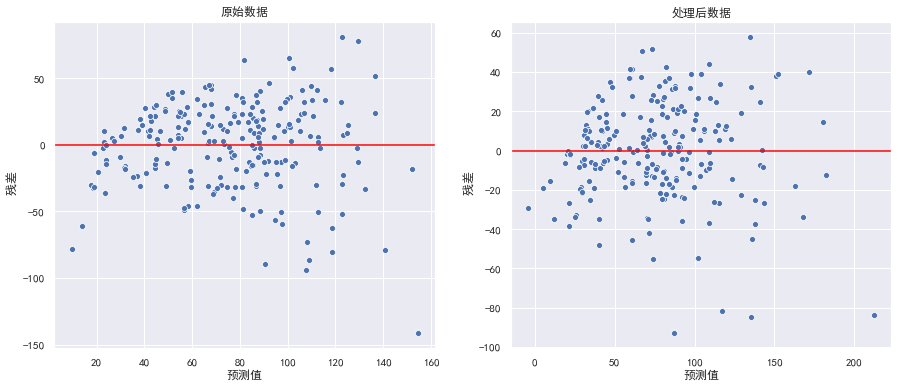

In [63]:
# 这里我们使用异常值处理前后两组数据，分别训练模型，观察残差效果
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
data = [X_train, X_train_dis]
title = ["原始数据", "处理后数据"]
for d, a, t in zip(data, ax, title):
    model = LinearRegression()
    model.fit(d, y_train)
    y_hat_train = model.predict(d)
    residual = y_hat_train - y_train.values
    a.set_xlabel("预测值")
    a.set_ylabel(" 残差")
    a.axhline(y=0, color="red")
    a.set_title(t)
    sns.scatterplot(x=y_hat_train, y=residual, ax=a)

从左图看，我们可以发现，随着预测值的增大，模型误差也增大。对于这种情况，我们可以对目标y做取对数处理。

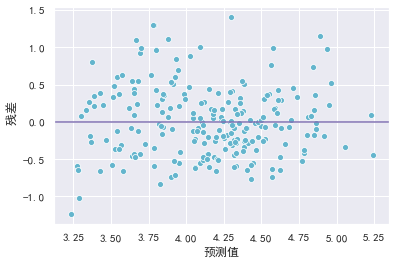

In [68]:
model = LinearRegression()
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
model.fit(X_train, y_train_log)

y_hat_train = model.predict(X_train)
residual = y_hat_train - y_train_log.values
plt.xlabel("预测值")
plt.ylabel("残差")
plt.axhline(y=0, color="m")
sns.scatterplot(x=y_hat_train, y=residual, color="c")

此时，异方差性得到解决，同时，模型效果也可能会得到一定程度上的提升

### 离群点
- 如果是简单线性回归，我们可以通过绘制回归线看出是否存在离群点。对于多元线性回归，其回归线已经扩展成为超平面，我们无法通过可视化进行观测
- 对于多元线性回归，我们可以通过绘制残差图，通过预测值与实际值之间的关系，来检测离群点

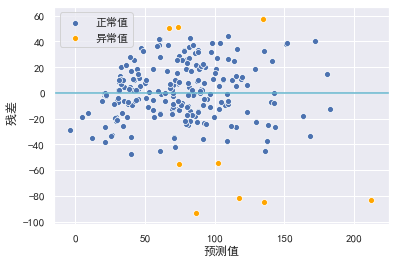

In [70]:
y_hat_train = lr.predict(X_train_dis)
residual = y_hat_train - y_train.values

r = (residual - residual.mean()) / residual.std()

plt.xlabel("预测值")
plt.ylabel(" 残差")
plt.axhline(y=0, color="c")
sns.scatterplot(x=y_hat_train[np.abs(r) <= 2], y=residual[np.abs(r) <= 2], color="b", label="正常值")
sns.scatterplot(x=y_hat_train[np.abs(r) > 2], y=residual[np.abs(r) > 2], color="orange", label="异常值")

In [71]:
# 剔除离群点，再次进行模型训练
X_train_dis_filter = X_train_dis[np.abs(r) <= 2]
y_train_filter = y_train[np.abs(r) <= 2]
lr.fit(X_train_dis_filter, y_train_filter)
print("训练集R^2：", lr.score(X_train_dis_filter, y_train_filter))
print("测试集R^2：", lr.score(X_test_dis, y_test))

0.7354141753913532
0.6302724058812208


模型效果得到进一步提升

# 总结
1. 空气质量总体分布上来说，南部城市优于北部城市，西部城市优于东部城市
2. 临海城市的空气质量整体上好于内陆城市
3. 是否临海、降雨量和纬度对空气质量的影响较大
4. 我国城市平均空气质量指数大致在（70.63 - 80.04）这个区间内，置信度95%
5. 通过历史数据，我们可以对空气质量指数进行预测